In [37]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existent cache directory
fc-cache: succeeded


In [38]:
import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic') 

### 라이브러리

In [39]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
from scipy.stats import chisquare
import matplotlib.pyplot as plt
import seaborn as sns

 ### 데이터 세트 불러오기

In [40]:
df = pd.read_csv('https://blog.kakaocdn.net/dn/dQwohr/btraDzfxxCn/C0eummSeMF4a7WIizJlRe1/vgames.csv?attach=1&knm=tfile.csv')
df.drop('Unnamed: 0',axis=1, inplace=True)
df.shape

(16598, 9)

### 데이터 **전처리**

**'K'와 'M'삭제 및 단위 맞춤**

In [41]:
def value_to_float(x):

    if 'K' in x:
        if len(x) > 1:
          return pd.to_numeric(x.replace('K', '')) / 1000
        return 1000.0
    if 'M' in x:
      if len(x) > 1:
        return pd.to_numeric(x.replace('M', ''))
    if not ('K' or 'M') in x:
       return x

df['NA_Sales'] = df['NA_Sales'].apply(value_to_float)
df['EU_Sales'] = df['EU_Sales'].apply(value_to_float)
df['JP_Sales'] = df['JP_Sales'].apply(value_to_float)
df['Other_Sales'] = df['Other_Sales'].apply(value_to_float)
df.iloc[138:141]


df.iloc[:,5:] = df.iloc[:,5:].astype(float)
df.iloc[138:141]

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
138,Warriors Orochi 3,PS4,2014.0,Action,Tecmo Koei,0.04,0.05,0.04,0.02
139,The Incredibles: Rise of the Underminer,PS2,2005.0,Action,THQ,0.18,0.14,0.00,0.05
140,Looney Tunes: Galactic Sports,PSV,2015.0,Action,Sony Computer Entertainment,0.00,0.06,0.00,0.02


**yy를 yyyy로 변경**

In [42]:
year1 = pd.to_datetime(df['Year'], errors='coerce', format='%Y')
year2 = pd.to_datetime(df['Year'], errors='coerce', format='%y')
df['Year'] = year1.fillna(year2)
df['Year']= df['Year'].dt.year
df.iloc[81:83]

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
81,Treasures of the Deep,PS,1997.0,Action,Namco Bandai Games,0.1,0.07,0.00,0.01
82,Mobile Suit Gundam: Perfect One Year War,PS,1997.0,Strategy,Namco Bandai Games,0.0,0.00,0.14,0.01


**결측치 확인**

In [43]:
df.isnull().sum()

Name             0
Platform         0
Year           271
Genre           50
Publisher       58
NA_Sales         0
EU_Sales         0
JP_Sales         0
Other_Sales      0
dtype: int64

In [44]:
df['Year'].fillna(0,inplace=True)
df[df['Year'] == 0].shape

(271, 9)

In [45]:
df['Publisher'].replace(np.nan,'Unknown', inplace = True)
df[df['Publisher'] == 'Unknown'].shape

(261, 9)

In [46]:
df['Genre'].replace(np.nan, 'Unknown', regex = True, inplace = True)
df[df['Genre'] == 'Unknown'].shape

(50, 9)

In [47]:
indexn1 = df[df['Year'] == 0].index
df.drop(indexn1, inplace = True)

indexn2 = df[df['Publisher'] == 'Unknown'].index
df.drop(indexn2, inplace = True)

indexn3 = df[df['Genre'] == 'Unknown'].index
df.drop(indexn3, inplace = True)

**중복 열 삭제**

In [48]:
df.drop_duplicates(keep=False,inplace=True)

**Outlier 확인**

In [49]:
max_thres = df.loc[:,'NA_Sales':].apply(lambda x : x.quantile(0.999))
max_thres

NA_Sales       9.52449
EU_Sales       6.03462
JP_Sales       4.13000
Other_Sales    2.05000
dtype: float64

In [50]:
#outlier 없는 것으로 결정
print(df[df['NA_Sales']>9.47455].sort_values(by='NA_Sales',ascending=False).head())
print(df[df['EU_Sales']>6.03462].sort_values(by='EU_Sales',ascending=False).head())
print(df[df['JP_Sales']>4.13000].sort_values(by='JP_Sales',ascending=False).head())
print(df[df['Other_Sales']>2.05000].sort_values(by='Other_Sales',ascending=False).head())


                    Name Platform    Year  ... EU_Sales JP_Sales  Other_Sales
2908          Wii Sports      Wii  2006.0  ...    29.02     3.77         8.46
4199   Super Mario Bros.      NES  1985.0  ...     3.58     6.81         0.77
10488          Duck Hunt      NES  1984.0  ...     0.63     0.28         0.47
1203              Tetris       GB  1989.0  ...     2.26     4.22         0.58
12579     Mario Kart Wii      Wii  2008.0  ...    12.88     3.79         3.31

[5 rows x 9 columns]
                     Name Platform    Year  ... EU_Sales JP_Sales  Other_Sales
2908           Wii Sports      Wii  2006.0  ...    29.02     3.77         8.46
12579      Mario Kart Wii      Wii  2008.0  ...    12.88     3.79         3.31
3352    Wii Sports Resort      Wii  2009.0  ...    11.01     3.28         2.96
11137          Nintendogs       DS  2005.0  ...    11.00     1.93         2.75
3483   Grand Theft Auto V      PS3  2013.0  ...     9.27     0.97         4.14

[5 rows x 9 columns]
              



---



---



### 1. 지역에 따라 선호하는 게임 장르가 다른가?


In [51]:
#1990년도 이후 지역의 장르별 출고량의 합
df_ge = df[df['Year']>=1990]
df_ge = df_ge.groupby('Genre')[['NA_Sales', 'EU_Sales', 'JP_Sales','Other_Sales']].sum()

format_dict = {'NA_Sales':'{:.2f}','EU_Sales':'{:.2f}','JP_Sales':'{:.2f}','Other_Sales':'{:.2f}'}
df_ge.style.format(format_dict).bar(['NA_Sales','EU_Sales','JP_Sales','Other_Sales'],color='lightblue',align='left')

,NA_Sales,EU_Sales,JP_Sales,Other_Sales
Genre,,,,
Action,819.86,508.77,147.31,183.32
Adventure,98.87,63.06,49.87,16.60
Fighting,216.83,99.21,84.18,36.04
Misc,390.29,207.23,99.23,72.44
Platform,370.94,187.21,98.08,49.20
Puzzle,77.63,44.80,43.71,11.26
Racing,347.80,232.54,52.21,75.94
Role-Playing,316.40,182.63,328.91,55.03
Shooter,523.43,307.37,32.88,101.05


**Chai-squared test(two-sample)**
- Null: 장르별 게임 구매비율은 지역과 무관하다.
- Alternative: 장르별 게임 구매 비율이 지역과 관련이 있다.

> 지역에따라 선호하는 게임의 장르는 서로 연관이 있다.



In [52]:
df_g = df_ge.astype('category')
chi2, p, dof, expected = chi2_contingency(df_g)
print('chai2:',chi2)
print('P-value:',p)

chai2: 670.2992763144568
P-value: 7.814372265368355e-120


일본을 제외했을 때에는 지역에 따라 선호하는 게임 장르는 다를까?
- Null: 장르별 게임 구매비율은 지역과 무관하다.
- Alternative: 장르별 게임 구매 비율이 지역과 관련이 있다.

> 장르별 게임 구매비율은 지역과 무관하다.

In [53]:
ex_j=df_ge.drop('JP_Sales',axis=1)
ex_j = ex_j.astype('category')
chi2, p, dof, expected = chi2_contingency(ex_j)
print('chai2:',chi2)
print('P-value:',p)

chai2: 23.883390575896726
P-value: 0.35337147615606257


In [54]:
format_dict1 = {'NA_Sales':'{:.2f}','EU_Sales':'{:.2f}','Other_Sales':'{:.2f}'}
ex_j.style.format(format_dict1).bar(['NA_Sales','EU_Sales','Other_Sales'],color='lightblue',align='left')

,NA_Sales,EU_Sales,Other_Sales
Genre,,,
Action,819.86,508.77,183.32
Adventure,98.87,63.06,16.60
Fighting,216.83,99.21,36.04
Misc,390.29,207.23,72.44
Platform,370.94,187.21,49.20
Puzzle,77.63,44.80,11.26
Racing,347.80,232.54,75.94
Role-Playing,316.40,182.63,55.03
Shooter,523.43,307.37,101.05




---



### 2. 연도별 게임 트랜드가 있나?

  1. 장르

In [55]:
#연도별 장르별 출고량의 합
genre = df.groupby(['Year','Genre'])[['NA_Sales', 'EU_Sales', 'JP_Sales','Other_Sales']].sum().reset_index()
genre['Total'] = genre.iloc[:,2:5].sum(axis=1)

#1990년도 부터의 장르별 트랜드
genre90 = genre[genre['Year']>=1990].drop(['NA_Sales', 'EU_Sales', 'JP_Sales','Other_Sales'],axis=1)

wide1 = genre90.pivot_table(index='Year',columns='Genre',values='Total')
wide1 = wide1.fillna(0)
wide1.head()

Genre,Action,Adventure,Fighting,Misc,Platform,Puzzle,Racing,Role-Playing,Shooter,Simulation,Sports,Strategy
Year,,,,,,,,,,,,
1990.0,6.25,0.00,0.00,0.00,22.41,5.86,5.78,4.50,0.00,1.11,2.06,0.00
1991.0,6.61,2.20,0.39,0.08,7.46,3.13,1.10,3.14,1.94,2.11,2.39,0.94
1992.0,3.71,11.95,14.91,4.82,13.07,4.76,8.87,6.83,0.28,2.04,2.90,0.35
1993.0,1.78,0.07,8.66,0.30,18.03,3.14,0.36,5.57,3.01,0.19,3.18,0.81
1994.0,1.53,3.74,8.27,2.76,27.63,1.53,2.13,7.09,7.95,2.67,8.28,3.44


- **Chai-squared test(two-sample)**
  - Null: 연도와 장르는 서로 독립적이다.
  - Alternative: 연도와 장르는 서로 연관이 있다.

> 연도와 장르는 서로 연관이 있다.

In [56]:
df_ygsum = wide1.astype('category')
chi2, p, dof, expected = chi2_contingency(df_ygsum)
print('chai2:',chi2)
print('P-value:',p)

chai2: 1649.0525735090107
P-value: 7.562444702664735e-182


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y, hue. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


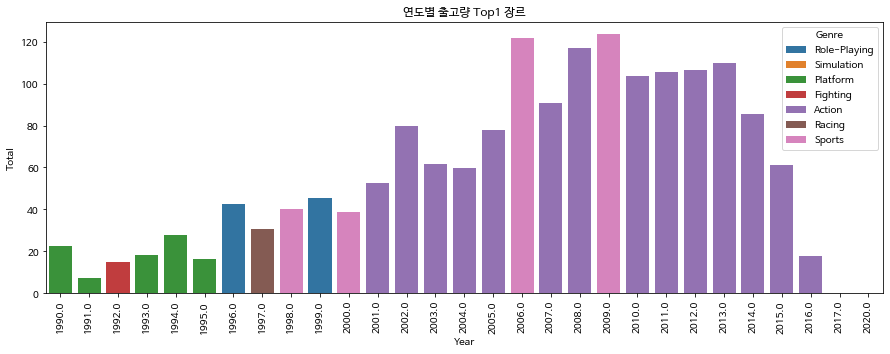

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y, hue. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


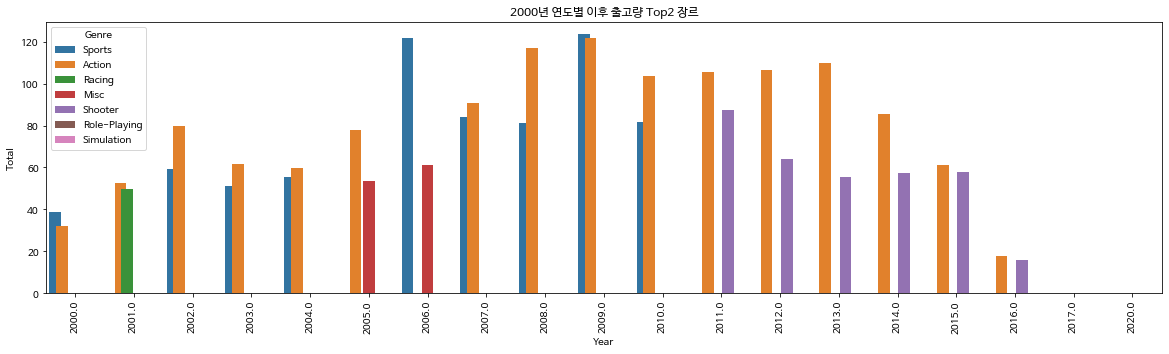

In [67]:

#연도별 출고량이 가장 많은 장르
genre_top = genre90.sort_values('Total').drop_duplicates('Year',keep='last')

#그래프
x = genre_top['Year']
y = genre_top['Total']
hue = genre_top['Genre']

fig, ax = plt.subplots(figsize=(15, 5))
ax = sns.barplot(x,y,hue,dodge=False)
ax.set_title('연도별 출고량 Top1 장르')
plt.xticks(rotation=90)
plt.show()

#2000년 이후 연도별 출고량이 많은 top2 장르
genre_top1 = genre90[genre90['Year']>=2000]
genre_top1 = genre_top1.groupby('Year').apply(lambda x: x.nlargest(2, 'Total')).reset_index(drop=True)

#그래프
x1 = genre_top1['Year']
y1 = genre_top1['Total']
hue1 = genre_top1['Genre']

fig, ax = plt.subplots(figsize=(20, 5))
ax = sns.barplot(x1,y1,hue1,data=genre_top1)
ax.set_title('2000년 연도별 이후 출고량 Top2 장르')
plt.xticks(rotation=90)

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        patch.set_width(new_value)

        patch.set_x(patch.get_x() + diff * .5)

change_width(ax, .2)
plt.show()

In [58]:
plat = df.groupby(['Year','Platform'])[['NA_Sales', 'EU_Sales', 'JP_Sales','Other_Sales']].sum().reset_index()
plat['Total'] = plat.iloc[:,2:5].sum(axis=1)

#1990년도 부터의 플랫폼별 트랜드
plat90 = plat[plat['Year']>=1990].drop(['NA_Sales', 'EU_Sales', 'JP_Sales','Other_Sales'],axis=1)

wide2 = plat90.pivot_table(index='Year',columns='Platform',values='Total')
wide2 = wide2.fillna(0)
wide2.head()

Platform,3DO,3DS,DC,DS,GB,GBA,GC,GEN,GG,N64,NES,NG,PC,PCFX,PS,PS2,PS3,PS4,PSP,PSV,SAT,SCD,SNES,TG16,WS,Wii,WiiU,X360,XB,XOne
Year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1990.0,0.00,0.0,0.0,0.0,4.46,0.0,0.0,2.52,0.00,0.0,15.51,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,25.48,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1991.0,0.00,0.0,0.0,0.0,5.49,0.0,0.0,4.20,0.00,0.0,5.95,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,15.85,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1992.0,0.00,0.0,0.0,0.0,24.85,0.0,0.0,12.27,0.04,0.0,1.95,0.00,2.9,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,32.48,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1993.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.65,0.00,0.0,3.55,0.21,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,1.45,39.24,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1994.0,0.02,0.0,0.0,0.0,11.58,0.0,0.0,7.82,0.00,0.0,0.11,0.80,12.4,0.0,5.63,0.0,0.0,0.0,0.0,0.0,3.63,0.36,34.67,0.0,0.0,0.0,0.0,0.0,0.0,0.0


- **Chai-squared test(two-sample)**
  - Null: 연도와 플랫폼은 서로 독립적이다.
  - Alternative: 연도와 플랫폼은 서로 연관이 있다.

> 연도와 플랫폼은 서로 연관이 있다.

In [59]:
df_ypsum = wide2.astype('category')
chi2, p, dof, expected = chi2_contingency(df_ypsum)
print('chai2:',chi2)
print('P-value:',p)

chai2: 26481.610339518258
P-value: 0.0


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y, hue. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


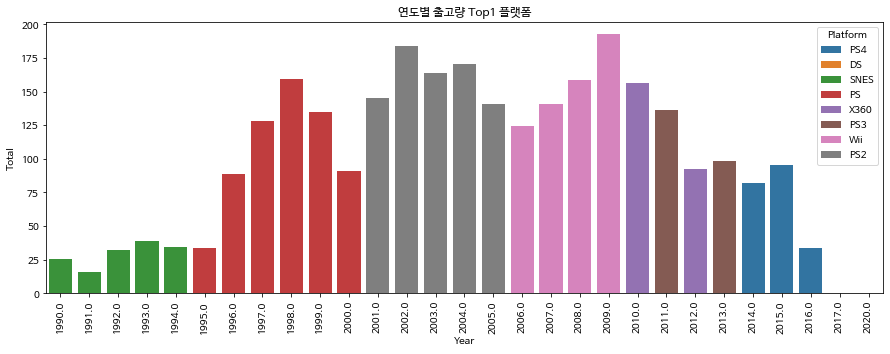

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y, hue. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


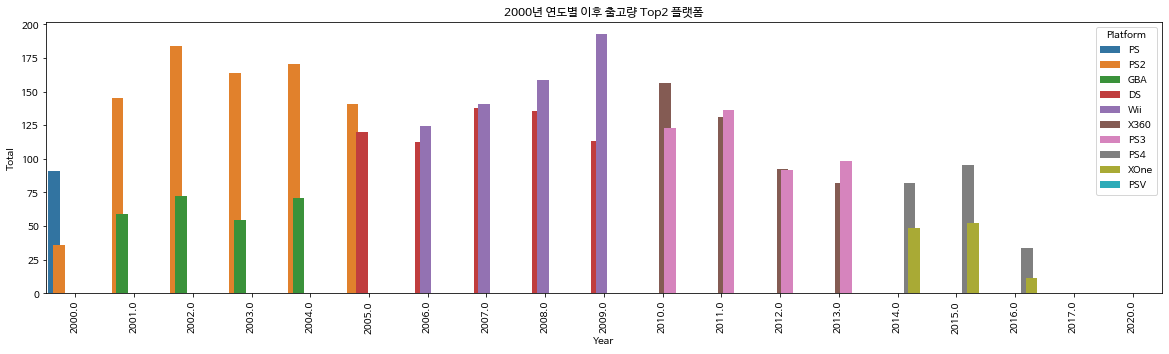

In [66]:
#연도별 출고량 가장 높은 플랫폼
plat_top = plat90.sort_values('Total').drop_duplicates('Year',keep='last')

#그래프
x = plat_top['Year']
y = plat_top['Total']
hue = plat_top['Platform']

fig, ax = plt.subplots(figsize=(15, 5))
ax = sns.barplot(x,y,hue,dodge=False)
ax.set_title('연도별 출고량 Top1 플랫폼')
plt.xticks(rotation=90)
plt.show()

#2000년 이후 연도별 출고량 높은 플랫폼 top2
plat_top1 = plat90[plat90['Year']>=2000]
plat_top1 = plat_top1.groupby('Year').apply(lambda x: x.nlargest(2, 'Total')).reset_index(drop=True)

#그래프
x1 = plat_top1['Year']
y1 = plat_top1['Total']
hue1 = plat_top1['Platform']

fig, ax = plt.subplots(figsize=(20, 5))
ax = sns.barplot(x1,y1,hue1,data=plat_top1)
ax.set_title('2000년 연도별 이후 출고량 Top2 플랫폼')
plt.xticks(rotation=90)

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

change_width(ax, .2)
plt.show()



---



### 3. 출고량이 높은 게임

In [61]:
df['sum'] = df.iloc[:,5:9].sum(axis=1)
df_top = df[df['Year']>=1990].sort_values(['sum'],ascending=False).reset_index(drop=True).head(300)
df_top

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,sum
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.83
2,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
3,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.38
4,New Super Mario Bros.,DS,2006.0,Platform,Nintendo,11.38,9.23,6.50,2.90,30.01
...,...,...,...,...,...,...,...,...,...,...
295,Namco Museum Vol.1,PS,1995.0,Misc,Sony Computer Entertainment,2.12,1.44,0.22,0.06,3.84
296,Flash Focus: Vision Training in Minutes a Day,DS,2007.0,Misc,Nintendo,0.87,1.57,1.05,0.35,3.84
297,The Legend of Zelda: Link's Awakening,GB,1992.0,Action,Nintendo,2.21,0.96,0.54,0.13,3.84
298,Big Brain Academy: Wii Degree,Wii,2007.0,Misc,Nintendo,1.06,1.93,0.41,0.43,3.83


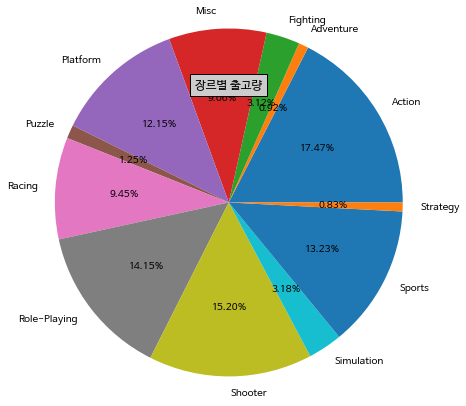

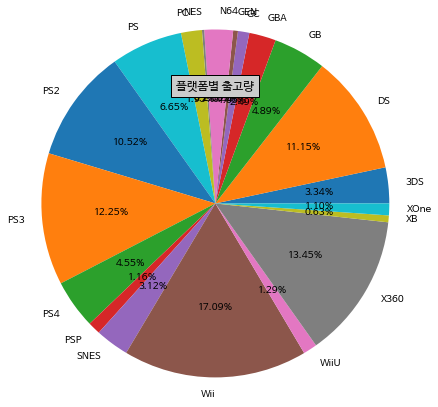

In [64]:
pie1 = df_top.groupby('Genre')['sum'].sum()
plt.title('장르별 출고량',bbox={'facecolor':'0.8', 'pad':5})
plt.pie(pie1, labels=pie1.index, autopct="%0.2f%%", radius = 2)

plt.show()


pie2 = df_top.groupby('Platform')['sum'].sum()
plt.title('플랫폼별 출고량',bbox={'facecolor':'0.8', 'pad':5})
plt.pie(pie2, labels=pie2.index, autopct="%0.2f%%", radius = 2)
plt.show()


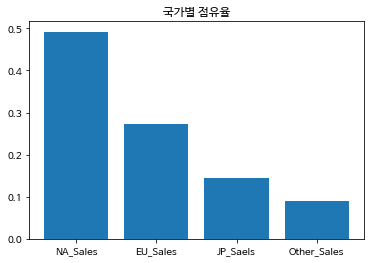

In [63]:
#국가별 시장 크기(비율)

NA = df['NA_Sales'].sum()/df['sum'].sum()
EU = df['EU_Sales'].sum()/df['sum'].sum()
JP = df['JP_Sales'].sum()/df['sum'].sum()
Oth = df['Other_Sales'].sum()/df['sum'].sum()

plt.bar(['NA_Sales','EU_Sales','JP_Saels','Other_Sales'],[NA,EU,JP,Oth])
plt.title('국가별 점유율')
plt.show()



---



---



일본을 제외한 지역별 선호 게임 장르는 비슷하다.

최근 게임은 Aciont과 Shooter가 인기가 많으며, playsation과 xbox를 플랫폼으로 많이 사용하고있다.

비록 출고량이 많은 데이터들 중 Platform이나 Role-Playing장르의 출고량이 많은 것으로 나타나지만, 이는 닌텐도의 영향인 것으로 추정한다. 최근 인기 장르가 많이 변했기 때문에 Action이나 Shooter장르가 인기가 많을 것으로 예상된다. 